# Capstone week 3 submission : Battle of Toronto neighbourhoods 

## Read the contents of the intersted table and store a CSV copy. 
*Note: The table is read in entirety without any cleaning done at this stage*

In [3]:
import pandas as pd
import numpy as np

tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0,
                      keep_default_na=False)

headings = ['Postal code', 'Borough', 'Neighborhood']
for table in tables:
    current_headings = table.columns.values[:3]
    if len(current_headings) != len(headings):
        continue
    if all(current_headings == headings):
        break

table[headings].to_csv('Toronto_neighborhoods.csv', sep=',', header=False, index=False)
df = table[headings]
df.head()

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


## Cleaning the dataset
### Remove all Boroughs with *Not Assigned* as value

In [4]:
df_NA_borough_removed = df[df.Borough != 'Not assigned']
df_NA_borough_removed.head()

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


### Check any Neighborhoods with *Not assigned* as value

In [5]:
df_NA_borough_removed[df_NA_borough_removed.Neighborhood == 'Not assigned'].shape

(0, 3)

## Skipping correction for Neighborhood == 'Not assigned' as none exist in this dataset

In [6]:
# Renaming the dataframe for brevity
df = df_NA_borough_removed
# Finding duplicate instances of Postal Code and joining the Neighborhoods. None exist
df['Neighborhood'] = df.groupby(['Postal code'])['Neighborhood'].transform(lambda x: ','.join(x))
# Dropping duplicate rows after the above joining
df.drop_duplicates()
# resetting index to start from 0
df.reset_index(drop=True, inplace=True)
#Rename 'Postal code' to 'PostalCode'
df.rename(columns={"Postal code": "PostalCode"}, inplace=True)
#Replace / separator with comma
df['Neighborhood'] = df['Neighborhood'].str.replace('/', ',')
df.head(12)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern , Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill , Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [7]:
print('Number of rows in the dataframe are {}.'.format(df.shape[0]))

Number of rows in the dataframe are 103.


## Tried and given up on *geocoder*. Reading the CSV instead

In [8]:
df_lat_long = pd.read_csv('http://cocl.us/Geospatial_data')
df_lat_long.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


## Joining the two dataframes on PostalCode ('Postal Code' on the latter) column 

In [9]:
df = df.set_index('PostalCode').join(df_lat_long.set_index('Postal Code'))
df.reset_index(inplace=True)
df.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill , Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


## Analysis of Toronto dataset
#### Using geopy package to get latitude and longitude of Toronoto to plot neighborhoods

In [2]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Creating a map of Toronto with all it neighborhoods superimposed on top

In [11]:
import folium
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Dropping all boroughs but those ending with Toronto

In [12]:
df_lim = df[df['Borough'].str.endswith(' Toronto', na=False)].reset_index(drop=True)
df_lim.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564
8,M5H,Downtown Toronto,"Richmond , Adelaide , King",43.650571,-79.384568
9,M6H,West Toronto,"Dufferin , Dovercourt Village",43.669005,-79.442259


In [14]:
df_lim.shape

(39, 5)

#### Visualising this restricted dataset

In [17]:
import folium
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_lim['Latitude'], df_lim['Longitude'], df_lim['Borough'], df_lim['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Defining FourSquare credentials and version

In [22]:
CLIENT_ID = 'Q2NWI2P41HG5ZNHAJXUXCKYYFVGZGVACNHWKJ2GEEQ2CEF5W' # your Foursquare ID
CLIENT_SECRET = 'SSCZ4VHDAVB4FN4FKQW5DB5ZVJS0XOWMV40SKAVUYIQG4MGP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Q2NWI2P41HG5ZNHAJXUXCKYYFVGZGVACNHWKJ2GEEQ2CEF5W
CLIENT_SECRET:SSCZ4VHDAVB4FN4FKQW5DB5ZVJS0XOWMV40SKAVUYIQG4MGP


#### Defining a function to GET all the Borough data
*Note: In contrast to New York, we have latitude, longitude data per postalcode and not neigborhood. Hence we are exploring by postalcode and not neighborhood*

In [36]:
import requests
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [37]:
# Calling the above function
toronto_venues = getNearbyVenues(names=df_lim['PostalCode'],
                                   latitudes=df_lim['Latitude'],
                                   longitudes=df_lim['Longitude']
                                  )

M5A
M7A
M5B
M5C
M4E
M5E
M5G
M6G
M5H
M6H
M5J
M6J
M4K
M5K
M6K
M4L
M5L
M4M
M4N
M5N
M4P
M5P
M6P
M4R
M5R
M6R
M4S
M5S
M6S
M4T
M5T
M4V
M5V
M4W
M5W
M4X
M5X
M4Y
M7Y


In [38]:
# Size and sample of this dataframe
print(toronto_venues.shape)
toronto_venues.head()

(1693, 7)


,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,M5A,43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,M5A,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,M5A,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


#### Number of venues returned per postalcode

In [39]:
toronto_venues.groupby('PostalCode').count()

,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
PostalCode,,,,,,
M4E,4,4,4,4,4,4
M4K,42,42,42,42,42,42
M4L,19,19,19,19,19,19
M4M,42,42,42,42,42,42
M4N,4,4,4,4,4,4
M4P,9,9,9,9,9,9
M4R,23,23,23,23,23,23
M4S,36,36,36,36,36,36
M4T,2,2,2,2,2,2


#### How many unique venue categories across which these venues are spread?

In [40]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


#### Make venue category into a categorical variable to facilitate clustering analysis

In [43]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add postalcode column to this new dataframe
toronto_onehot['PostalCode'] = toronto_venues['PostalCode'] 

# move postalcode column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,PostalCode,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Group by postalcode and record means

In [45]:
toronto_grouped = toronto_onehot.groupby('PostalCode').mean().reset_index()
toronto_grouped

,PostalCode,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M4E,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.250000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
1,M4K,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.023810,0.000000,...,0.023810,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.023810
2,M4L,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,M4M,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.047619,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.023810,0.000000,0.000000,0.00,0.023810
4,M4N,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
5,M4P,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,M4R,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.043478
7,M4S,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
8,M4T,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
9,M4V,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.058824,0.000000,...,0.000000,0.00,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.00,0.000000


In [49]:
toronto_grouped.columns

Index(['PostalCode', 'Afghan Restaurant', 'Airport', 'Airport Food Court',
       'Airport Gate', 'Airport Lounge', 'Airport Service', 'Airport Terminal',
       'American Restaurant', 'Antique Shop',
       ...
       'Trail', 'Train Station', 'Vegetarian / Vegan Restaurant',
       'Video Game Store', 'Vietnamese Restaurant', 'Wine Bar', 'Wine Shop',
       'Wings Joint', 'Women's Store', 'Yoga Studio'],
      dtype='object', length=237)

#### Printing each postalcode with 5 most frequent venue categories

In [47]:
num_top_venues = 5

for code in toronto_grouped['PostalCode']:
    print("----"+code+"----")
    temp = toronto_grouped[toronto_grouped['PostalCode'] == code].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----M4E----
               venue  freq
0       Neighborhood  0.25
1                Pub  0.25
2  Health Food Store  0.25
3              Trail  0.25
4      Movie Theater  0.00


----M4K----
                    venue  freq
0        Greek Restaurant  0.21
1             Coffee Shop  0.10
2      Italian Restaurant  0.07
3          Ice Cream Shop  0.05
4  Furniture / Home Store  0.05


----M4L----
               venue  freq
0     Sandwich Place  0.11
1          Pet Store  0.05
2                Pub  0.05
3  Fish & Chips Shop  0.05
4            Brewery  0.05


----M4M----
         venue  freq
0         Café  0.10
1  Coffee Shop  0.07
2    Gastropub  0.05
3       Bakery  0.05
4      Brewery  0.05


----M4N----
               venue  freq
0               Park  0.25
1             Lawyer  0.25
2           Bus Line  0.25
3        Swim School  0.25
4  Afghan Restaurant  0.00


----M4P----
               venue  freq
0     Breakfast Spot  0.11
1               Park  0.11
2   Asian Restaurant  0.11
3   De

In [50]:
# Sorting the categories by freq
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Creating a dataframe that shows the top 10 venue categories for each postalcode

In [54]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
df_venues_sorted = pd.DataFrame(columns=columns)
df_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    df_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

df_venues_sorted.head()

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,Trail,Neighborhood,Health Food Store,Pub,Yoga Studio,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,M4K,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bookstore,Furniture / Home Store,Lounge,Spa,Juice Bar,Brewery
2,M4L,Sandwich Place,Ice Cream Shop,Pub,Liquor Store,Burrito Place,Restaurant,Fast Food Restaurant,Italian Restaurant,Fish & Chips Shop,Steakhouse
3,M4M,Café,Coffee Shop,American Restaurant,Bakery,Brewery,Gastropub,Yoga Studio,Fish Market,Pet Store,Park
4,M4N,Park,Lawyer,Swim School,Bus Line,Yoga Studio,Discount Store,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store


### K-means clustering after finding the ideal K

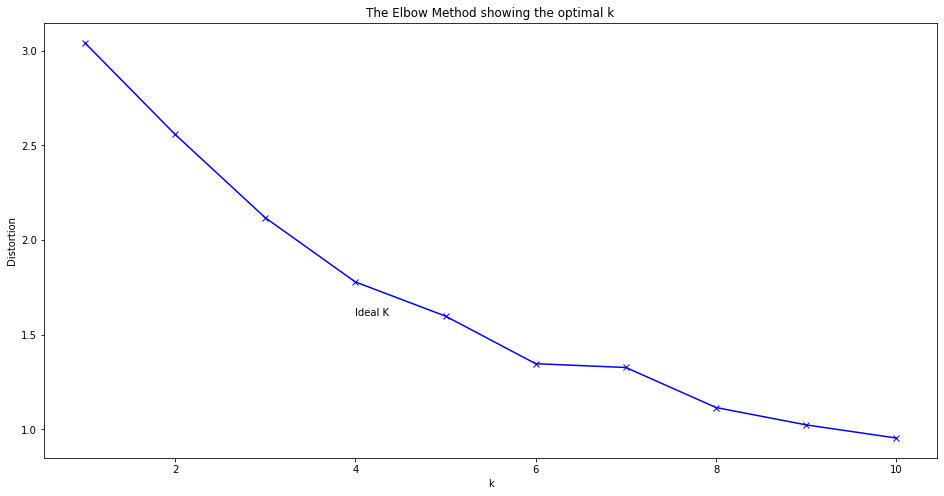

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans

toronto_grouped_clustering = toronto_grouped.drop('PostalCode', 1)
distortions = []
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.text(4, distortions[4], 'Ideal K')
plt.show()

#### Based on the above choosing K = 4

In [58]:
# run k-means clustering
kmeans = KMeans(n_clusters=4).fit(toronto_grouped_clustering)


#### Creating a dataset that includes top 10 venue categories plus cluster labels

In [59]:
# add clustering labels
df_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_lim

# merge toronto_grouped with toronto_data to add latitude/longitude for each postalcode
toronto_merged = toronto_merged.join(df_venues_sorted.set_index('PostalCode'), on='PostalCode')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,0,Coffee Shop,Pub,Park,Theater,Breakfast Spot,Café,Bakery,Restaurant,Mexican Restaurant,Yoga Studio
1,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Yoga Studio,Mexican Restaurant,Beer Bar,Italian Restaurant,Juice Bar,Burger Joint,Burrito Place,Café,Distribution Center
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Japanese Restaurant,Cosmetics Shop,Restaurant,Thai Restaurant,Pizza Place,Fast Food Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Italian Restaurant,Restaurant,Japanese Restaurant,Diner,Bakery,American Restaurant,Breakfast Spot,Clothing Store
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Trail,Neighborhood,Health Food Store,Pub,Yoga Studio,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop


#### Visualizing the clusters

In [62]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
kclusters = 4
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examining clusters and gaining insights

In [63]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Pub,Park,Theater,Breakfast Spot,Café,Bakery,Restaurant,Mexican Restaurant,Yoga Studio
1,Downtown Toronto,0,Coffee Shop,Yoga Studio,Mexican Restaurant,Beer Bar,Italian Restaurant,Juice Bar,Burger Joint,Burrito Place,Café,Distribution Center
2,Downtown Toronto,0,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Japanese Restaurant,Cosmetics Shop,Restaurant,Thai Restaurant,Pizza Place,Fast Food Restaurant
3,Downtown Toronto,0,Coffee Shop,Café,Italian Restaurant,Restaurant,Japanese Restaurant,Diner,Bakery,American Restaurant,Breakfast Spot,Clothing Store
4,East Toronto,0,Trail,Neighborhood,Health Food Store,Pub,Yoga Studio,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
5,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Seafood Restaurant,Beer Bar,Bakery,Farmers Market,Restaurant,Cheese Shop,Café,Diner
6,Downtown Toronto,0,Coffee Shop,Italian Restaurant,Thai Restaurant,Japanese Restaurant,Burger Joint,Sandwich Place,Gym / Fitness Center,Spa,Middle Eastern Restaurant,Ice Cream Shop
7,Downtown Toronto,0,Grocery Store,Café,Park,Gas Station,Italian Restaurant,Candy Store,Restaurant,Diner,Athletics & Sports,Baby Store
8,Downtown Toronto,0,Restaurant,Coffee Shop,Café,Bar,Bakery,Thai Restaurant,Office,Hotel,Lounge,Cosmetics Shop
9,West Toronto,0,Pharmacy,Bakery,Gym / Fitness Center,Pool,Fast Food Restaurant,Café,Recording Studio,Supermarket,Bar,Bank


In [92]:
class0_cats = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[list(range(6, toronto_merged.shape[1]))]]
class0_cats_series = pd.melt(class0_cats).groupby(['value']).count()
class0_cats_series.sort_values(by=['variable'], ascending=False, inplace=True)
class0_cats_series

,variable
value,
Coffee Shop,25
Café,24
Restaurant,22
Italian Restaurant,13
Bakery,10
...,...
Mediterranean Restaurant,1
Cheese Shop,1
Caribbean Restaurant,1


#### Based on this group's venues they can be classified as postcode containing lots of *Coffee shops, cafes & Restaurants*

In [95]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,1,Gym,Playground,Dessert Shop,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


#### This postcode seem to be forming its own class with venues such as *Gym, Playground, Dessert shop, etc*

In [97]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,2,Pool,Health & Beauty Service,Garden,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio


#### This postcode again seem to be forming its own class with venues such as *Pool, Health & Beauty Service, Garden, etc*

In [99]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,3,Park,Lawyer,Swim School,Bus Line,Yoga Studio,Discount Store,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store
33,Downtown Toronto,3,Park,Playground,Trail,Yoga Studio,Dessert Shop,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [100]:
class3_cats = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[list(range(6, toronto_merged.shape[1]))]]
class3_cats_series = pd.melt(class3_cats).groupby(['value']).count()
class3_cats_series.sort_values(by=['variable'], ascending=False, inplace=True)
class3_cats_series

,variable
value,
Electronics Store,2
Empanada Restaurant,2
Ethiopian Restaurant,2
Park,2
Yoga Studio,2
Bus Line,1
Dessert Shop,1
Discount Store,1
Dumpling Restaurant,1


#### This cluster of postcode seems to have a preference for *Park, Yoga studio, Ethiopian/Empanada restaurants and electronics stores*